In [ ]:
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader

In [ ]:
import numpy as np
import pandas as pd
import pickle
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from ucsc_genomes_downloader import Genome
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

### Constants

In [ ]:
[cell_line, assembly, window_size] = ['HepG2', 'hg38', 256]

In [ ]:
def load_epigenomes_and_labels(cell_line, assembly, window_size):
    epigenomes = {
        "promoters": {},
        "enhancers": {}
    }

    labels = {
        "promoters": {},
        "enhancers": {}
    }

    epigenomes["promoters"], labels["promoters"] =\
        active_promoters_vs_inactive_promoters(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            window_size = window_size,
            root = "datasets",
            metric='mean'
        )

    epigenomes["enhancers"], labels["enhancers"] =\
        active_enhancers_vs_inactive_enhancers(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            window_size = window_size,
            root = "datasets",
            metric='mean'
        )
    return epigenomes,labels

In [ ]:
epigenomes, labels = load_epigenomes_and_labels(cell_line = cell_line, assembly = assembly, window_size = window_size)

In [ ]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [ ]:
genome = Genome(assembly)
genome

KNN Inputer fills nan values within the given  dataframe using knn

In [ ]:
def knn_imputer(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )
epigenomes['promoters'] = knn_imputer(epigenomes['promoters'])
epigenomes['enhancers'] = knn_imputer(epigenomes['enhancers'])

### Dropping Const Features

In [ ]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    return df. loc[:, (df != df.iloc[0]).any()]
    
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


### Scaling using Z-Scoring

In [ ]:
def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )
    
epigenomes = {
    region: robust_zscoring(x) for region, x in epigenomes.items()
}

### Label Clipping
99th quartile is used to remive outliers frim the data

In [ ]:
quantile_99_promoters = np.ceil(np.quantile(labels['promoters'], q=0.99))
quantile_99_enhancers = np.ceil(np.quantile(labels['enhancers'], q=0.99))

labels['promoters'][labels['promoters']>quantile_99_promoters] = quantile_99_promoters
labels['enhancers'][labels['enhancers']>quantile_99_enhancers] = quantile_99_enhancers

### Label Binarization

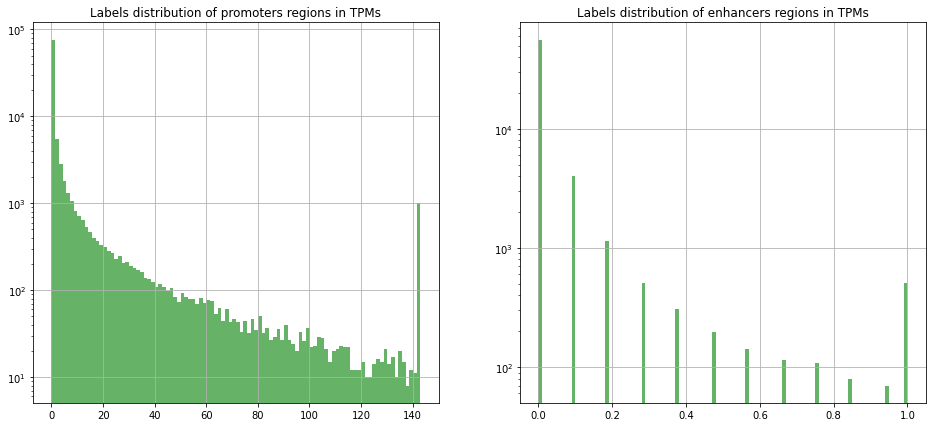

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
for i, region in enumerate(labels.items()):
    region[1]["HEPG2"].hist(log=True, 
                           ax=axes[i],
                           bins=100,
                           alpha=0.6, 
                           color='green')
    axes[i].set_title(f"Labels distribution of {region[0]} regions in TPMs")

In [ ]:
tentative_binarized_labels = {
    "promoters": {},
    "enhancers": {}
}
tentative_labels = {
    "promoters": {},
    "enhancers": {}
}

tentative_labels['enhancers'] = labels['enhancers'][(labels['enhancers'] <= 0.0 ) | (labels['enhancers'] >= 1.0)].dropna()
tentative_labels['promoters'] = labels['promoters'][(labels['promoters'] <= 0.0 ) | (labels['promoters'] >= 1.0)].dropna()

tentative_binarized_labels['promoters'] = labels['promoters']  >= 1.0 
tentative_binarized_labels['enhancers'] = labels['enhancers']  >= 1.0

binarized_labels = {
    "promoters": {},
    "enhancers": {}
}

binarized_labels['promoters'] = labels['promoters']  > 1.0
binarized_labels['enhancers'] = labels['enhancers']  > 0.0

/tmp/ipykernel_3053/1774997324.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


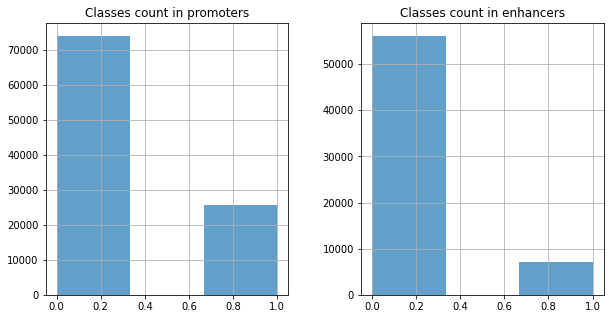

In [ ]:
#The threshold 1.0 is used to distinguish between active and inactive promoters/enancher
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, y) in zip(axes.ravel(), binarized_labels.items()):
    (y).astype(int).hist(ax=axis, bins=3, alpha=0.7)
    axis.set_title(f"Classes count in {region}")
fig.show()

In [ ]:
print(f" The Imbalance ratio of promoters is {len(binarized_labels['promoters'][binarized_labels['promoters']==False].dropna()) /len(binarized_labels['promoters'][binarized_labels['promoters']==True].dropna()) } ")
print(f" The Imbalance ratio of enhancers is {len(binarized_labels['enhancers'][binarized_labels['enhancers']==False].dropna()) /len(binarized_labels['enhancers'][binarized_labels['enhancers']==True].dropna()) } ") 

 The Imbalance ratio of promoters is 2.8740594213016832 
 The Imbalance ratio of enhancers is 7.817751149505364 


By doing this we can find out which dataset is more trainable

In [ ]:
with open('./epigenomes/epigenomes_promoters.pkl', 'wb') as f:
    pickle.dump(epigenomes["promoters"], file=f)
with open('./epigenomes/epigenomes_enhancers.pkl', 'wb') as f:
    pickle.dump(epigenomes["enhancers"], file=f)
with open('./epigenomes/labels_promoters.pkl', 'wb') as f:
    pickle.dump(labels["promoters"], file=f)
with open('./epigenomes/labels_enhancers.pkl', 'wb') as f:
    pickle.dump(labels["enhancers"], file=f)
with open('./epigenomes/binarized_labels_promoters.pkl', 'wb') as f:
    pickle.dump(binarized_labels['promoters'], file=f)
with open('./epigenomes/binarized_labels_enhancers.pkl', 'wb') as f:
    pickle.dump(binarized_labels['enhancers'], file=f)

### Tests

In [ ]:
import unittest

class Test(unittest.TestCase):
    def test_drop_costant_features(self):
        constant_df = pd.DataFrame([[0, 0],[0, 1]])
        constant_df = drop_constant_features(constant_df)
        self.assertEqual( len(constant_df.columns), 1)
    def test_knn(self):
        epigenomes,_ = load_epigenomes_and_labels(cell_line = cell_line, assembly = assembly, window_size = 256)
        #Testing there are no NaN values after imputation
        self.assertEqual(knn_imputer(epigenomes['promoters']).isna().values.sum(), 0)
        self.assertEqual(knn_imputer(epigenomes['enhancers']).isna().values.sum(), 0)

In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)


test_drop_costant_features (__main__.Test) ... ok
test_knn (__main__.Test) ... ok

----------------------------------------------------------------------
Ran 2 tests in 84.363s

OK
